In [1]:
import sys
sys.path.append('..')
import os
from os.path import join
import numpy as np
import pandas as pd
import connattractor.network as network
import connattractor.analysis as analysis
import pickle

import seaborn as sns
sns.set_style("whitegrid")

In [3]:
%pip install mlxtend

  Using cached mlxtend-0.23.0-py3-none-any.whl (1.4 MB)

[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: /home/renglert/PycharmProjects/connattractor/venv/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [13]:
base_path = '../../connattractor/data_out/'

data = {
    #'abide_ctr': base_path + 'abide/mtx_abite_ctr.csv',
    #'abide_path': base_path + 'abide/mtx_abite_path.csv',
    #'adni_ctr': base_path + 'adni/mtx_adni_mci.csv',
    #'adni_path': base_path + 'adni/mtx_adni_ad.csv',
    'cobre_ctr': base_path + 'cobre/mtx_cobre_ctr.csv',
    'cobre_path': base_path + 'cobre/mtx_cobre_sch.csv'
}

with open('../data_out/default_hopfield_embedding_0.37.pkl', 'rb') as file:
    hopfield_embedding = pickle.load(file)

/home/renglert/PycharmProjects/connattractor/venv/lib/python3.8/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.2.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/renglert/PycharmProjects/connattractor/venv/lib/python3.8/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.2.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [14]:
noise = 0.37

simresults_all = {}
hopfield_embeddings_all = {}

for key, path in data.items():
    mtx = pd.read_csv(path, header=None)
    
    simresults_all[key] = analysis.simulate_activations(mtx.values, noise_coef=noise, 
                                                          num_iter=100000, beta=0.04, random_state=2023)
    hopfield_embeddings_all[key] = analysis.create_embeddings(simresults_all[key], 
                                                                attractor_sample=1000,random_state=2023)

100%|██████████| 1000/1000 [00:46<00:00, 21.58it/s]


# state transitions

In [15]:
def calc_tmat(att_labels, num_states=None, return_ratios=True):
    if num_states == None:
        num_states = len(np.unique(att_labels))
        
    transition_matrix = np.zeros((num_states, num_states))

    for i in range(len(att_labels) - 1):
        current_state = att_labels[i]
        next_state = att_labels[i + 1]
        transition_matrix[current_state, next_state] += 1
        
    if return_ratios:
        transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)
        return np.nan_to_num(transition_matrix)
    else:
        return transition_matrix


# load cobre data

In [16]:
base_path = '../../connattractor/notebooks/'

order = pd.read_csv('../data_in/MIST122_relabeled.tsv', sep='\t').iloc[:, 1:]
pheno = pd.read_csv(base_path + 'cobre_data/data_cobre_neuropsych.csv')

all_data = pd.DataFrame(columns=pheno.columns)

timeseries = []

for id in pheno.id:
    if os.path.exists(base_path + 'cobre_data/BASC/regions/' + id + '_timeseries.txt'):

        ts = np.loadtxt(base_path + 'cobre_data/BASC/networks/' + id + '_timeseries.txt')
        #reorder columns in ts based on order['index']
        ts = ts[:, order['index'].values-1]
        timeseries.append(ts)
        all_data.loc[id, pheno.columns] = pheno.loc[pheno.id == id, pheno.columns].values
        
all_data['study_group_int'] = pd.Categorical(all_data.study_group).codes
all_data['gender_int'] = pd.Categorical(all_data.gender).codes

idx_ctr = np.where(all_data.study_group=='Control')[0]
idx_path = np.where(all_data.study_group=='Schizophrenia')[0]

In [17]:
# split timeseries into group and flatten along subjects
ts_ctr = np.array(timeseries)[idx_ctr].reshape(-1, 122)
ts_path = np.array(timeseries)[idx_path].reshape(-1, 122)

In [18]:
# predict attractor state labels in reference projection
embedded_ts = hopfield_embedding.embedding_model.transform(ts_ctr)[:,:2]
labels_ctr = hopfield_embedding.attractor_model.predict(embedded_ts)
labels_ctr

embedded_ts = hopfield_embedding.embedding_model.transform(ts_path)[:,:2]
labels_path = hopfield_embedding.attractor_model.predict(embedded_ts)
labels_path

array([1, 2, 2, ..., 2, 2, 2])

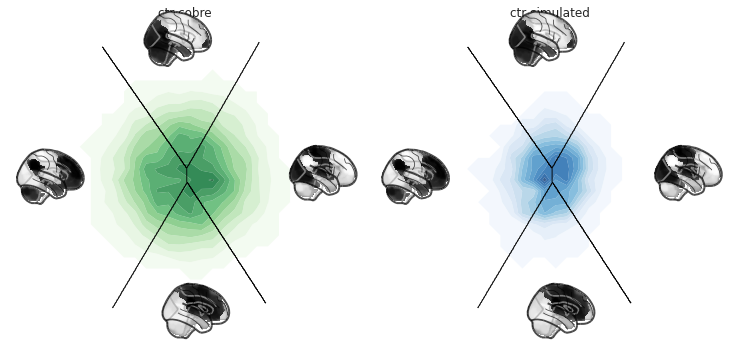

In [10]:
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(ncols=2, subplot_kw={'projection': 'polar'}, figsize=(12, 8))

hopfield_embedding.plot(ts_ctr, plot_type='contourf', ax=ax[0],
                        density_bins=30, density_sigma=0.5, levels=12, alpha=0.8, cmap='Greens',
                        attractor_plot_type='glassbrain', attractor_kwargs=dict(cmap='binary'),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )
ax[0].set_title('ctr cobre')
ax[0].set_yticks([])
ax[0].grid(False)


hopfield_embedding.plot(hopfield_embeddings_all['cobre_ctr'].state_sample, 
                        plot_type='contourf', ax=ax[1],
                        density_bins=30, density_sigma=0.5, levels=12, alpha=0.8, cmap='Blues',
                        attractor_plot_type='glassbrain', attractor_kwargs=dict(cmap='binary'),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )
ax[1].set_title('ctr simulated')
ax[1].set_yticks([])
ax[1].grid(False)


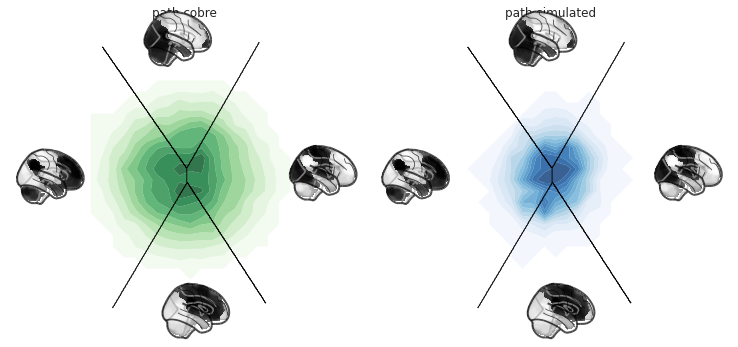

In [122]:
fig, ax = plt.subplots(ncols=2, subplot_kw={'projection': 'polar'}, figsize=(12,8))

hopfield_embedding.plot(ts_path, plot_type='contourf', ax=ax[0],
                        density_bins=30, density_sigma=0.5, levels=12, alpha=0.8, cmap='Greens',
                        attractor_plot_type='glassbrain', attractor_kwargs=dict(cmap='binary'),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )
ax[0].set_title('path cobre')
ax[0].set_yticks([])
ax[0].grid(False)

hopfield_embedding.plot(hopfield_embeddings_all['cobre_path'].state_sample, 
                        plot_type='contourf', ax=ax[1],
                        density_bins=30, density_sigma=0.5, levels=12, alpha=0.8, cmap='Blues',
                        attractor_plot_type='glassbrain', attractor_kwargs=dict(cmap='binary'),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )
ax[1].set_title('path simulated')
ax[1].set_yticks([])
ax[1].grid(False)

## state transitions cobre ts

[Text(0.5, 15.0, 'to state'), Text(33.0, 0.5, 'from state')]

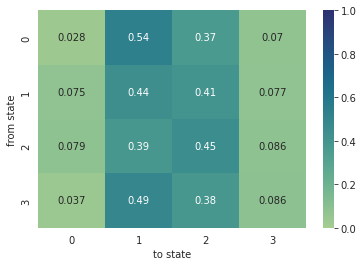

In [123]:
tmat_ctr = calc_tmat(labels_ctr)
ax = sns.heatmap(tmat, cmap="crest", vmin=0, vmax=1, annot=True)
ax.set(xlabel="to state", ylabel="from state")

[Text(0.5, 15.0, 'to state'), Text(33.0, 0.5, 'from state')]

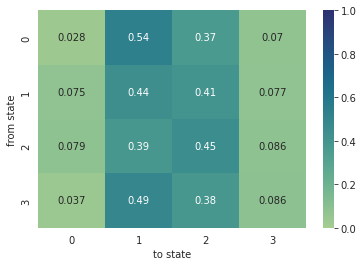

In [124]:
tmat_path = calc_tmat(labels_path)
ax = sns.heatmap(tmat, cmap="crest", vmin=0, vmax=1, annot=True)
ax.set(xlabel="to state", ylabel="from state")

[Text(0.5, 15.0, 'to state'), Text(33.0, 0.5, 'from state')]

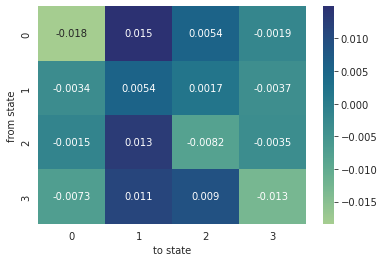

In [126]:
ax = sns.heatmap(tmat_path-tmat_ctr, cmap="crest",  annot=True)
ax.set(xlabel="to state", ylabel="from state")

## state transitions simulated cobre data

[Text(0.5, 15.0, 'to state'), Text(33.0, 0.5, 'from state')]

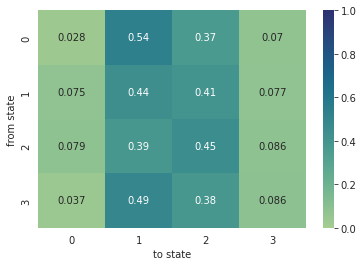

In [127]:
import seaborn as sns

data_key = 'cobre_ctr'

# state sample from clinical connectome
state_sample = hopfield_embeddings_all[data_key].state_sample

# transform to reference projection and predict labels
embedded_states = hopfield_embedding.embedding_model.transform(state_sample)[:, :2]
labels_states = hopfield_embedding.attractor_model.predict(embedded_states)

tmat_ctr_sim = calc_tmat(labels_states)

ax = sns.heatmap(tmat, cmap="crest", vmin=0, vmax=1, annot=True)
ax.set(xlabel="to state", ylabel="from state")

[Text(0.5, 15.0, 'to state'), Text(33.0, 0.5, 'from state')]

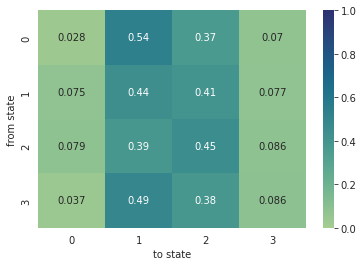

In [128]:
data_key = 'cobre_path'

# state sample from clinical connectome
state_sample = hopfield_embeddings_all[data_key].state_sample

# transform to reference projection and predict labels
embedded_states = hopfield_embedding.embedding_model.transform(state_sample)[:, :2]
labels_states = hopfield_embedding.attractor_model.predict(embedded_states)

tmat_path_sim = calc_tmat(labels_states)

ax = sns.heatmap(tmat, cmap="crest", vmin=0, vmax=1, annot=True)
ax.set(xlabel="to state", ylabel="from state")

[Text(0.5, 15.0, 'to state'), Text(33.0, 0.5, 'from state')]

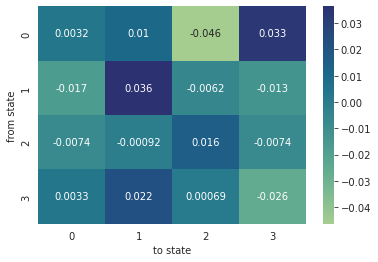

In [129]:
ax = sns.heatmap(tmat_path_sim-tmat_ctr_sim, cmap="crest",  annot=True)
ax.set(xlabel="to state", ylabel="from state")

[Text(0.5, 15.0, 'to state'), Text(33.0, 0.5, 'from state')]

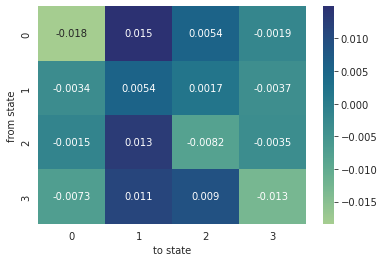

In [130]:
ax = sns.heatmap(tmat_path-tmat_ctr, cmap="crest",  annot=True)
ax.set(xlabel="to state", ylabel="from state")

# look at streamplots

In [105]:
def add_relative_streamplot_original(projection1, projection2,
                             stream_bins=30, ax=None, max_r=None, **kwargs):
    from scipy.stats import binned_statistic_2d
    
    if ax is None:
        ax = plt.gca()
    if max_r is None:
        max_r = np.max(np.abs(np.vstack((projection1, projection2))))
    
    default_kwargs = dict(linewidth=5, density=1.2)
    default_kwargs.update(kwargs)
    stream_linewidth = default_kwargs.pop('linewidth')
    
    directions1 = projection1[1:, :] - projection1[:-1, :]

    dir_x_1, x_edges, y_edges, _ = binned_statistic_2d(projection1[:-1, 1], projection1[:-1, 0], directions1[:, 0],
                                                    statistic=np.mean,
                                                    bins=[np.linspace(-max_r*1.1, max_r*1.1, stream_bins),
                                                    np.linspace(-max_r*1.1, max_r*1.1, stream_bins)])
    dir_y_1, x_edges, y_edges, _ = binned_statistic_2d(projection1[:-1, 1], projection1[:-1, 0], directions1[:, 1],
                                                    statistic=np.mean,
                                                    bins=[np.linspace(-max_r * 1.1, max_r * 1.1,
                                                                      stream_bins),
                                                          np.linspace(-max_r * 1.1, max_r * 1.1,
                                                                      stream_bins)])

    directions2 = projection2[1:, :] - projection2[:-1, :]

    dir_x_2, x_edges, y_edges, _ = binned_statistic_2d(projection2[:-1, 1], projection2[:-1, 0], directions2[:, 0],
                                                    statistic=np.mean,
                                                    bins=[np.linspace(-max_r*1.1, max_r*1.1, stream_bins),
                                                    np.linspace(-max_r*1.1, max_r*1.1, stream_bins)])
    dir_y_2, x_edges, y_edges, _ = binned_statistic_2d(projection2[:-1, 1], projection2[:-1, 0], directions2[:, 1],
                                                    statistic=np.mean,
                                                    bins=[np.linspace(-max_r * 1.1, max_r * 1.1,
                                                                      stream_bins),
                                                          np.linspace(-max_r * 1.1, max_r * 1.1,
                                                                      stream_bins)])
    
    density, x_edges, y_edges = np.histogram2d(projection2[:-1, 1], projection2[:-1, 0],
                                                     bins=[np.linspace(-max_r * 1.1, max_r * 1.1,
                                                                      stream_bins),
                                                          np.linspace(-max_r * 1.1, max_r * 1.1,
                                                                      stream_bins)],
                                                     density=True,
                                                     )

    x, y = np.meshgrid(x_edges[:-1],
                       y_edges[:-1])

    dir_x = dir_x_2-dir_x_1
    dir_y = dir_y_2-dir_y_1

    speed = np.sqrt(dir_x ** 2 + dir_y ** 2)

    ax_cart = ax.figure.add_axes(ax.get_position(), polar=False, frameon=False, zorder=-1)
    #ax_cart.set_xlim(ax.get_xlim())
    #ax_cart.set_ylim(ax.get_xlim())
    ax_cart.streamplot(x, y, dir_x, dir_y,
                        #linewidth= stream_linewidth * speed / speed[~ np.isnan(speed)].max(),
                       color = density,
                      **default_kwargs)
    return ax_cart, dir_x, dir_y

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic_2d

def add_relative_streamplot(projection1, projection2, stream_bins=30, ax=None, max_r=None, rad_lim=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    if max_r is None:
        max_r = np.max(np.abs(np.vstack((projection1, projection2))))
        
    if rad_lim is None:
        rad_lim = max_r
    
    default_kwargs = dict(linewidth=5, density=1.2)
    default_kwargs.update(kwargs)
    stream_linewidth = default_kwargs.pop('linewidth')
    
    directions1 = projection1[1:, :] - projection1[:-1, :]
    directions2 = projection2[1:, :] - projection2[:-1, :]

    dir_x_1, x_edges, y_edges, _ = binned_statistic_2d(
        projection1[:-1, 1], projection1[:-1, 0], directions1[:, 0],
        statistic=np.mean,
        bins=[np.linspace(-max_r*1.1, max_r*1.1, stream_bins),
              np.linspace(-max_r*1.1, max_r*1.1, stream_bins)])
    
    dir_y_1, x_edges, y_edges, _ = binned_statistic_2d(
        projection1[:-1, 1], projection1[:-1, 0], directions1[:, 1],
        statistic=np.mean,
        bins=[np.linspace(-max_r * 1.1, max_r * 1.1, stream_bins),
              np.linspace(-max_r * 1.1, max_r * 1.1, stream_bins)])

    dir_x_2, x_edges, y_edges, _ = binned_statistic_2d(
        projection2[:-1, 1], projection2[:-1, 0], directions2[:, 0],
        statistic=np.mean,
        bins=[np.linspace(-max_r*1.1, max_r*1.1, stream_bins),
              np.linspace(-max_r*1.1, max_r*1.1, stream_bins)])
    
    dir_y_2, x_edges, y_edges, _ = binned_statistic_2d(
        projection2[:-1, 1], projection2[:-1, 0], directions2[:, 1],
        statistic=np.mean,
        bins=[np.linspace(-max_r * 1.1, max_r * 1.1, stream_bins),
              np.linspace(-max_r * 1.1, max_r * 1.1, stream_bins)])
    
    density, x_edges, y_edges = np.histogram2d(
        projection2[:-1, 1], projection2[:-1, 0],
        bins=[np.linspace(-max_r * 1.1, max_r * 1.1, stream_bins),
              np.linspace(-max_r * 1.1, max_r * 1.1, stream_bins)],
        density=True)

    x, y = np.meshgrid(x_edges[:-1], y_edges[:-1])

    dir_x = dir_x_2 - dir_x_1
    dir_y = dir_y_2 - dir_y_1

    speed = np.sqrt(dir_x ** 2 + dir_y ** 2)

    ax_cart = ax.figure.add_axes(ax.get_position(), polar=False, frameon=False, zorder=-1)
    
    # Set limits and ticks for the polar axis, to prevent automatic scaling
    ax_cart.set_xlim(-rad_lim * 1.1, rad_lim * 1.1)  # Set the radial limits
    ax_cart.set_ylim(-rad_lim * 1.1, rad_lim * 1.1)  # Set the radial limits
    ax_cart.set_xticks([])  # Remove angular ticks
    ax_cart.set_yticks([])  # Remove radial ticks

    ax_cart.streamplot(x, y, dir_x, dir_y,
                       color=density,
                       **default_kwargs)
    
    return ax_cart, dir_x, dir_y


[]

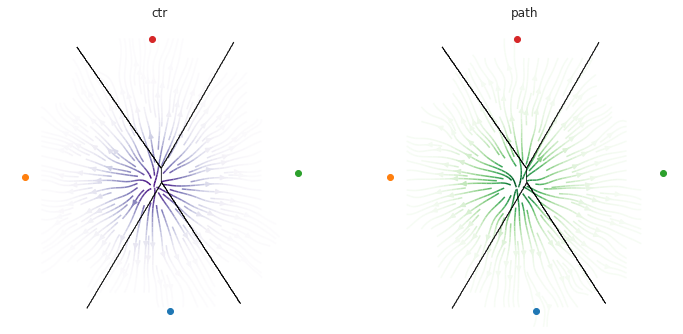

In [19]:
random = np.random.default_rng(2023)
perm_ctr  = random.permutation(np.arange(ts_ctr.shape[0]))
perm_path  = random.permutation(np.arange(ts_path.shape[0]))


embedded_ctr = hopfield_embedding.embedding_model.transform(ts_ctr)
embedded_ctr_perm = hopfield_embedding.embedding_model.transform(ts_ctr[perm_ctr, :])

embedded_path = hopfield_embedding.embedding_model.transform(ts_path)
embedded_path_perm = hopfield_embedding.embedding_model.transform(ts_path[perm_path, :])


fig, ax = plt.subplots(ncols = 2, subplot_kw={'projection': 'polar'}, figsize=(12, 6))

hopfield_embedding.plot(ts_ctr, plot_type='contourf', ax=ax[0],
                    density_bins=50, density_sigma=0, levels=12, alpha=0, cmap='Purples',
                    attractor_plot_type='scatter',# attractor_kwargs=dict(cmap='binary'),
                    regimes_fill_kwargs=dict(alpha=0.0),
                    regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                   )
ax_cart, dir_x, dir_y = add_relative_streamplot(embedded_ctr_perm, embedded_ctr, ax=ax[0],
                                  stream_bins = 20, density=2, linewidth=5, max_r=10, cmap='Purples')

ax[0].set_title('ctr')
ax[0].set_yticks([])
ax[0].grid(False)
ax_cart.set_yticks([])
#ax_cart.grid(False)

hopfield_embedding.plot(ts_path, plot_type='contourf', ax=ax[1],
                    density_bins=50, density_sigma=0.5, levels=12, alpha=0, cmap='Greens',
                    attractor_plot_type='scatter',# attractor_kwargs=dict(cmap='binary'),
                    regimes_fill_kwargs=dict(alpha=0.0),
                    regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                   )
ax_cart, dir_x, dir_y = add_relative_streamplot(embedded_path_perm, embedded_path, ax=ax[1],
                                 stream_bins = 20, density=2, linewidth=5, max_r=10, cmap='Greens')

ax[1].set_title('path')
ax[1].set_yticks([])
ax[1].grid(False)
ax_cart.set_yticks([])
#ax_cart.grid(False)


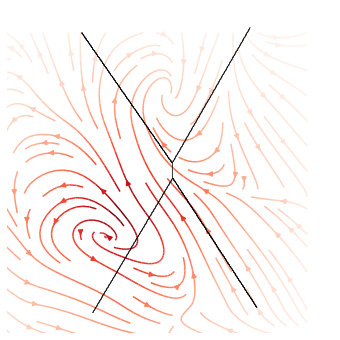

In [20]:
embedded_ctr = hopfield_embedding.embedding_model.transform(ts_ctr)
embedded_path = hopfield_embedding.embedding_model.transform(ts_path)


fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(12, 6))

hopfield_embedding.plot(ts_path, plot_type='contourf', ax=ax,
                    density_bins=10, density_sigma=0, levels=12, alpha=0, cmap='Reds',
                    attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                    regimes_fill_kwargs=dict(alpha=0.0),
                    regimes_contour_kwargs=dict(alpha=1, colors='black')
                   )

ax_cart, dir_x, dir_y = add_relative_streamplot(embedded_ctr, embedded_path, ax=ax, max_r=7, rad_lim=5,
                                  stream_bins = 6, density=1, linewidth=6, cmap='Reds')

dirs_sch_vs_hc_empirical = np.vstack((dir_x, dir_y))


ax.set_yticks([])
ax.grid(False)
ax_cart.set_yticks([])
ax_cart.set_xticks([])
ax_cart.grid(False)

# try to reproduce the schizophrenia dynamics

### "Activity flow underlying abnormalities in brain activations and cognition in schizophrenia"
These regions of interest (ROI) included the (Glasser parc.)
- left ventral anterior cingulate cortex (ACC, parcel 57, cingulo-opercular network), 
- right medial superior temporal area (MST, parcel 182, higher order visual network), 
- right posterior operculum of the sylvian fissure (PO, parcel 285, cingulo-opercular network), 
- the right posterior insula (PI, parcel 347, cingulo-opercular network)

In [5]:
import nibabel as nib
glasser_parcellation = nib.load('../data_in/glasser360MNI.nii.gz')

header = glasser_parcellation.header
data = glasser_parcellation.get_fdata()

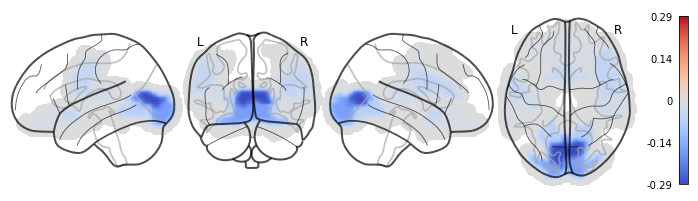

In [6]:
signal_amp = -1
target_roi = [56, 181, 284, 346]

signal_image = np.zeros_like(data)
#signal_image[data == target_roi] = signal_amp
signal_image[np.isin(data, target_roi)] = signal_amp

signal_nifti = nib.Nifti1Image(signal_image, affine=glasser_parcellation.affine)

sch_map = network.State(signal_nifti)
sch_map.plot()

100%|██████████| 50000/50000 [00:25<00:00, 1978.25it/s]


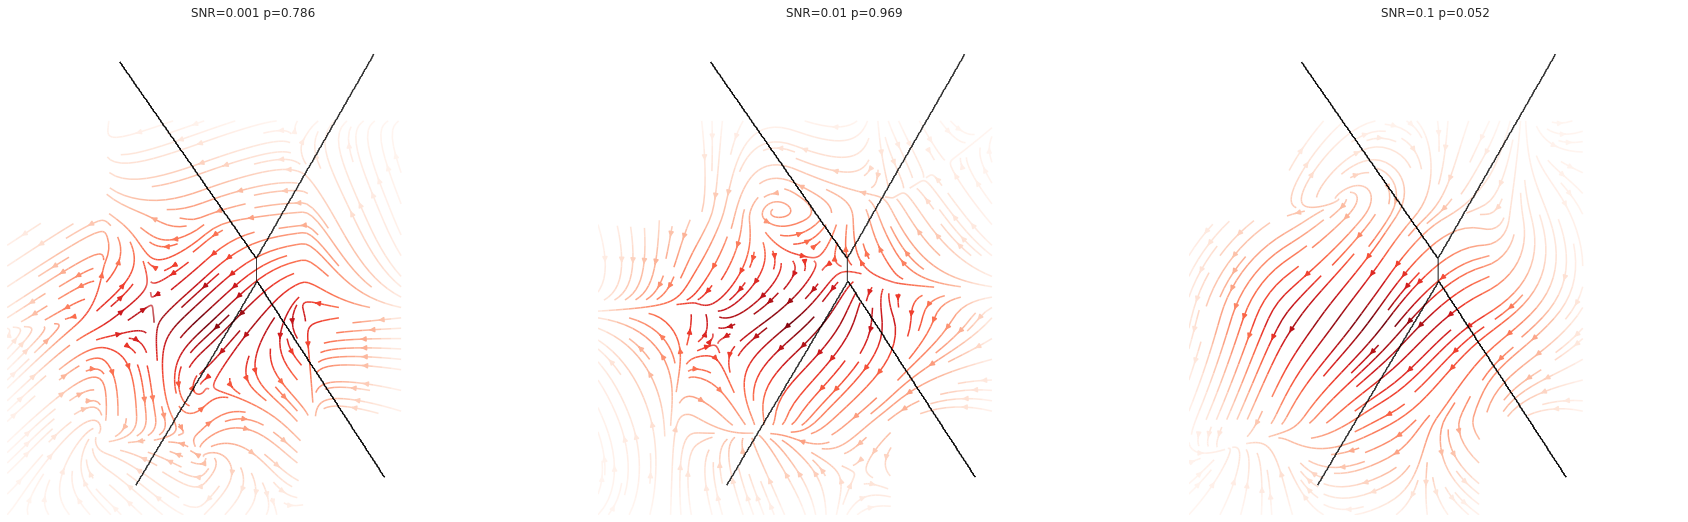

In [25]:
from mlxtend.evaluate import permutation_test
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

connfile = '../data_in/ex_connectome_partial_correlation.csv'

mtx = pd.read_csv(connfile).iloc[:, 1:]

simresults_rest = analysis.simulate_activations(mtx.values, noise_coef=0.37, 
                                                      num_iter=50000, beta=0.04,
                                                      random_state=42)

fig, ax = plt.subplots(ncols = 3, subplot_kw={'projection': 'polar'}, figsize=(30, 15))

#for i, SNR in enumerate(np.logspace(-3,-1, 5)):
for i, SNR in enumerate([0.001, 0.01, 0.1]):

    signal = np.array(sch_map)

    simresults_sch = analysis.simulate_activations(mtx.values, noise_coef=0.37,
                                                          num_iter=50000, beta=0.04,
                                                          signal = signal * SNR,
                                                          random_state=42)

    embedded_rest = hopfield_embedding.embedding_model.transform(simresults_rest.states)
    embedded_sch = hopfield_embedding.embedding_model.transform(simresults_sch.states)

    np.max(np.abs(np.vstack((embedded_rest, embedded_sch))))



    hopfield_embedding.plot(simresults_sch.states, plot_type='contourf', ax=ax[i],
                        density_bins=20, density_sigma=0, levels=12, alpha=0, cmap='Reds',
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )
    ax_cart, dir_x, dir_y  = add_relative_streamplot(embedded_rest, embedded_sch, ax=ax[i], max_r=4,
                                      stream_bins = 6, density=1.3, linewidth=6, cmap='Reds')
    dirs_sch_vs_rest_simulated = np.vstack((dir_x, dir_y))
    
    p_value = permutation_test(dirs_sch_vs_hc_empirical[~np.isnan(dirs_sch_vs_rest_simulated)],
                           dirs_sch_vs_rest_simulated[~np.isnan(dirs_sch_vs_rest_simulated)],
                           func=lambda x, y: spearmanr(x, y).correlation,
                           method='approximate',
                           num_rounds=10000,
                           seed=42)

    ax[i].set_title('SNR=' + str(np.round(SNR,3)) + ' p=' + str(np.round(p_value, 3)))
    ax[i].set_yticks([])
    ax[i].grid(False)
    ax_cart.set_yticks([])
    ax_cart.grid(False)
